## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv(r"ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df[df.converted == 1].shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group != 'treatment') & (df.landing_page == 'new_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isna().any(axis=1).sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) | ((df['group'] == 'control') == (df['landing_page'] == 'old_page'))]
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep=False)].user_id.iloc[0]

773192

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset=['user_id'])

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2[df2.converted == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[(df2.converted == 1) & (df2.group == "control")].shape[0] / df2[df2.group == "control"].shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[(df2.converted == 1) & (df2.group == "treatment")].shape[0] / df2[df2.group == "treatment"].shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[(df2.landing_page == "new_page")].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

with the probability in b being higher than the probability in c, it could be assumed that the new page is better than the old one, yet the sample size for each group of users using a specific page may not be sufficents for websites having thousands of users each hour like amazon or udacity. this leads us the use of bootstrapping and hypothesis testing just to be sure about our conclusions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

null hypothesis: **$p_{new}$** - **$p_{old}$** <= 0


alternative hypothesis: **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

conversation regardless of the page

In [18]:
conv_rate = df2[df2.converted == 1].shape[0] / df2.shape[0]
conv_rate

0.11959708724499628

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
conv_rate

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
conv_rate

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2[(df2.group == 'treatment')].shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2[(df2.group == 'control')].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.zeros(n_new)
new_page_converted[:17292] = 1
np.random.shuffle(new_page_converted)
new_page_converted = pd.DataFrame(new_page_converted, columns = ['converted'])
print(new_page_converted.shape, np.sum(new_page_converted) / new_page_converted.shape[0])

(145310, 1) converted    0.119001
dtype: float64


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.zeros(n_old)
old_page_converted[:17288] = 1
np.random.shuffle(old_page_converted)
old_page_converted = pd.DataFrame(old_page_converted, columns = ['converted'])
print(old_page_converted.shape, np.sum(old_page_converted.converted) / old_page_converted.shape[0])

(145274, 1) 0.1190027121164145


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new = np.sum(new_page_converted) / new_page_converted.shape[0]
p_old = np.sum(old_page_converted) / old_page_converted.shape[0]
p_new - p_old, 3

(converted   -0.000002
 dtype: float64, 3)

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

p_diffs = []
sample = df2.sample(df2.shape[0])
df_size = df2.shape[0]
for i in range(10000):
    if i % 1000 == 0:
        print(i/100)
    boot_sample = sample.sample(sample.shape[0],replace=True)
    old_p_conv = boot_sample[(boot_sample.group == 'control') & (boot_sample.converted == 1)].shape[0] / df_size
    new_p_conv = boot_sample[(boot_sample.group == 'treatment') & (boot_sample.converted == 1)].shape[0] / df_size
    p_diffs.append(old_p_conv - new_p_conv)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [26]:
p_diffs = []
sample = df2.sample(df2.shape[0])
ctrl_size = sample[sample.group == 'control'].shape[0]
trt_size = sample[sample.group == 'treatment'].shape[0]
for i in range(10000):
    if i % 1000 == 0:
        print(i/100)
    boot_sample = sample.sample(sample.shape[0],replace=True)
    old_p_conv = boot_sample[(boot_sample.group == 'control') & (boot_sample.converted == 1)].shape[0] / ctrl_size
    new_p_conv = boot_sample[(boot_sample.group == 'treatment') & (boot_sample.converted == 1)].shape[0] / trt_size
    p_diffs.append(new_p_conv - old_p_conv)

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


(array([   8.,   58.,  366., 1383., 2689., 2921., 1818.,  615.,  129.,
          13.]),
 array([-0.00676798, -0.00576516, -0.00476234, -0.00375952, -0.0027567 ,
        -0.00175388, -0.00075106,  0.00025176,  0.00125458,  0.0022574 ,
         0.00326022]),
 <a list of 10 Patch objects>)

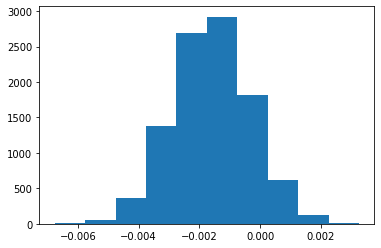

In [27]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

proportion of the p_diffs are greater than the actual difference of-0.0015782389853555567 in ab_data:  0.8974


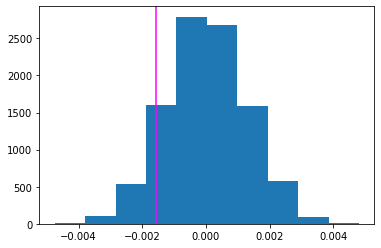

In [28]:
old_and_converted = df2[(df2.group == 'control') & (df2.converted == 1)].shape[0] / df2[df2.group == 'control'].shape[0]
new_and_converted = df2[(df2.group == 'treatment') & (df2.converted == 1)].shape[0] / df2[df2.group == 'treatment'].shape[0]
actual_diff = new_and_converted - old_and_converted
std = np.std(p_diffs)
null_vals = np.random.normal(0, std, 10000)

prop = (null_vals > actual_diff).sum() / null_vals.shape[0]
plt.hist(null_vals)
plt.axvline(x=actual_diff, color = 'magenta')
print("proportion of the p_diffs are greater than the actual difference of" +str(actual_diff)+" in ab_data: ",prop)

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

after calculating the sampling distribution of p_diffs in part h, we simulate the null hypothesis with a normal distribution where the mean of that distribution is the 0 of the null hypothesis and the standard divation is obtained from the sampling distribution in h. we then calculate the p value of of the actual difference in ab_data (which is considered in this case a sample) to see if the null hypothesis hold or if there is significent evidence to reject the null hypothesis. with a p value "that we computed in j" = .8 being greater than the type 1 error (alpha) which is .05, we fail to reject the null hypothesis

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[(df2.group == 'control') & (df2.converted == 1)].shape[0] 
convert_new = df2[(df2.group == 'treatment') & (df2.converted == 1)].shape[0] 
n_old = df2[(df2.group == 'control')].shape[0]
n_new = df2[(df2.group == 'treatment')].shape[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")
print(stat, pval)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

the z score indicates the difference between the proporations of two samples which in our case are the converation rate in the old and new page. the p-value on the other hand indicates the significence of the difference indicated by the z score. with our results from the z-test, we failt to reject the null hypothesis given that the p-value > 5% which supports our findings in j and h.  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

the logistic regression model as this task could be regarded as a classification one

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['control', 'treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis=1)
df2 = df2.rename(columns = {'treatment':'ab_page'})
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
model =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])

results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-04-18 18:47 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [34]:
np.exp(-0.0150)

0.9851119396030626

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

the p-value associated with ab_page is .189. this p-value indicates that there is a very weak relation between an increased user conversion and the new landing page, this relation can be expressed as " a user conversion  on a new page is 0.985 as likely as a user conversion on the old page". with the p-value being > 0.05, we can conclude that the new page is not statistically significent in relation to the conversion rate which supports the findings in part2

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

other factors or features could give us better understanding and modeling regarding the conversion rate as it we could consider all the favtors that infulence the convesrion rate. yet, some factors may not have any influence on our caluclations and could lead to false predictions, these favtors are what is called noisy features.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new = df_new.drop(['CA','CA_ab_page'], axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [41]:
model2 =sm.Logit(df_new['converted'],df_new[['intercept', 'UK', 'US']])

results = model2.fit()
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-04-18 18:55 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

In [48]:
np.exp(0.0507), np.exp(0.0408)

(1.052007243765014, 1.0416437559600236)

based on the p-values, the relation between the country and the conversion is weak as the the p values are > 0.05 (the findings are not significent). these relations could be intrepated as "for UK (or US) the conversion is 1.05 (1.04 for us) as likly for CA" which indicates very minimal effect on the conversions for each country.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
model3 =sm.Logit(df_new['converted'],df_new[['intercept','ab_page', 'US', 'UK', 'UK_ab_page', 'US_ab_page']])

results = model3.fit()
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-04-18 18:58 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [49]:
np.exp(0.0783), np.exp(0.0469)

(1.0814470441230692, 1.048017202119183)

after considering the p-values we can conclude that the neither the country nor the new page design increase the number of converted people as the all the p-values are > 0.0 and the the liklihood of conversion when considering the interaction between the country and the page is roughly the same for all interactions (UK_ab_page, US_ab_page, _ab_page).

In conclusion, the various analysis indicates that neither the type of the page nor the country of the user increased the conversions. regarding the design, the new design performed as equally (or a little bit worse) than the old page design. For the possible residences of users, all countries had roughly the same conversion rate. as for the interaction between the page design and the country, the different permutations proved the fact that the new page performed as equal or worse than the old page regardless of the country. 